### MAST30034: Applied Data Science Project 1
---
# Data Analysis: FHVHV Dataset
#### Xavier Travers (1178369)

Performs data analysis to relate the COVID dataset and FHVHV aggregate dataset

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/15 00:33:13 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.22.173.58 instead (on interface eth0)
22/08/15 00:33:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/15 00:33:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/15 00:33:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# read in the aggregated yellow tlc data
tlc_pu_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,pu_borough,population,num_*,num_pc_*,num_p100k_*,avg_passengers,avg_trip_distance
2020,4,2020-04-25,121,keep for graphing,Queens,2395791.0,1612,6.728466715168394E-4,67.28466715168393,1.1457816377171215,6.7971650124069445
2020,4,2020-04-04,118,keep for graphing,Queens,2395791.0,2342,9.775477076255817E-4,97.75477076255817,1.2314261315115287,7.5416652433817255
2020,7,2020-07-25,134,post,Brooklyn,2727393.0,1930,7.076354599428832E-4,70.76354599428832,1.2279792746113989,2.8218341968911953
2020,6,2020-06-13,128,post,Brooklyn,2727393.0,1313,4.814121030595884E-4,48.14121030595884,1.300837776085301,3.505689261233818
2020,4,2020-04-04,118,keep for graphing,Manhattan,1687834.0,51640,0.030595425853490333,3059.5425853490333,1.2797637490317584,2.3961254841208284


In [4]:
# read in the aggregated covid data
flu_df = spark.read.parquet('../data/curated/virals/flu/aggregated/cases-by-week')
flu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,borough,population,tot_cases,tot_pc_cases,tot_p100k_cases
2020,3,2020-03-21,116,keep for graphing,Staten Island,495522.0,30.0,6.054221608727766E-5,6.054221608727766
2019,5,2019-05-11,71,pre,Bronx,1418207.0,18.0,1.269208232648689...,1.2692082326486895
2019,12,2019-12-14,102,keep for graphing,Manhattan,1628706.0,259.0,1.590219474846903E-4,15.90219474846903
2021,12,2021-12-18,207,neither,Staten Island,493494.0,207.0,4.194579873311529...,41.945798733115296
2020,10,2020-10-31,148,post,Bronx,1466438.0,2.0,1.363849000094105...,0.13638490000941056


In [5]:
# join the datasets by week_index
joined_pu_df = jh.join_by_week_by_borough(tlc_pu_df, flu_df, 'flu')

### Timeline 1

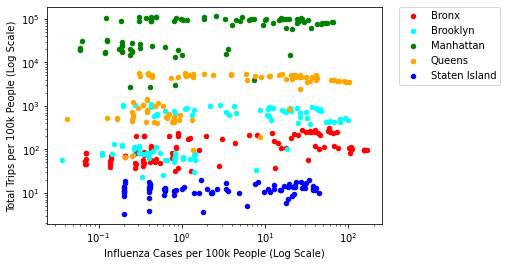

In [6]:
# plot a time-series histogram to show how average weekly trips changes per week
ph.scatter(joined_pu_df.toPandas(), 'flu_tot_p100k_cases', 'num_p100k_*', 
    xlabel = 'Influenza Cases per 100k People', 
    ylabel = 'Total Trips per 100k People', logx = True, logy = True)

### Timeline 2

In [ ]:
# remove data outside of the post timeline
joined_pu_pre_df = joined_pu_df.where(F.col('timeline') == 'post')

In [ ]:
# plot a time-series histogram to show how average weekly trips changes per week
ph.scatter(joined_pu_pre_df.toPandas(), 'flu_tot_p100k_cases', 'num_p100k_*', 
    xlabel = 'Influenza Cases per 100k People', 
    ylabel = 'Total Trips per 100k People', logx = True, logy = True)

### Timeline 3

In [7]:
# remove data outside of the post timeline
joined_pu_post_df = joined_pu_df.where(F.col('timeline') == 'post')

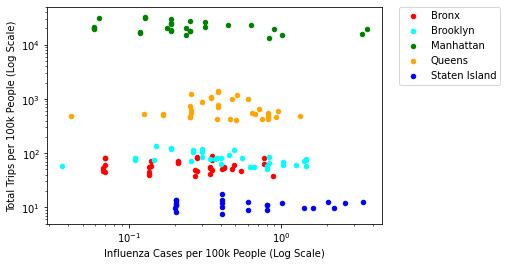

In [8]:
# plot a time-series histogram to show how average weekly trips changes per week
ph.scatter(joined_pu_post_df.toPandas(), 'flu_tot_p100k_cases', 'num_p100k_*', 
    xlabel = 'Influenza Cases per 100k People', 
    ylabel = 'Total Trips per 100k People', logx = True, logy = True)